# Model comparison example

For $\cot^{-1}\phi \in (1, 4)$
- $\phi \sim \text{TruncatedNormal}(\mu_\phi, \sigma_\phi, 0, 90)$
- $\phi \sim \text{Uniform}(\cot^{-1}4, \cot^{-1}1)$
- $\cot(\phi) \sim \text{Uniform}(1, 4)$

In [1]:
import numpy as np
import scipy.stats as st
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns

Could not import matplotlib.animation 'ascii' codec can't decode byte 0xc2 in position 90: ordinal not in range(128)


In [2]:
cot = lambda phi: 1 / np.tan(np.radians(phi))
acot = lambda a: np.degrees(np.arctan(1 / a))

Define some core values to ensure consistent samples:

## Dataset creation

We'll create a series of mock datasets, each corresponding to a different possible reality. We choose to truncate each dataset to between $\cot^{-1}4$ and $\cot^{-1}1$.


The normally distributed dataset is chosen to be close to the cot-uniform dataset.

In [3]:
np.random.seed(0)

# number of galaxies in the sample
N_GALS = 100
# Mean number of arms per galaxy
MU_N_ARMS = 1.7
# normal_dataset
MU_PHI = 14.76377094845352
# inter-galaxy pitch angle std (between galaxies in the sample)
SD_PHI = 12.775146676186282
# intra-galaxy pitch angle std (between arms in the galaxy)
SD_GAL = 10

In [4]:
# generate a number of arms for each galaxy
n_arms = st.poisson(MU_N_ARMS).rvs(N_GALS)
# and an array of galaxy index for each arm
gal_arm_map = np.concatenate([
    np.tile(i, n_arms[i])
    for i in range(len(n_arms))
])
def get_arm_pas(gal_pa, n=1, sd=SD_GAL, lower=0, upper=90):
    a = (lower - gal_pa) / SD_PHI
    b = (upper - gal_pa) / SD_PHI
    return st.truncnorm(a, b, loc=gal_pa, scale=sd).rvs(n)

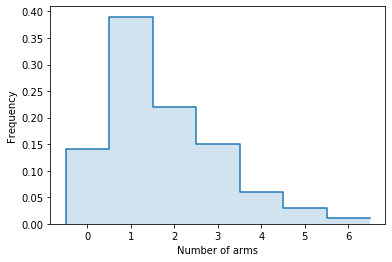

In [5]:
count, bins, _ = plt.hist(n_arms, bins=np.arange(n_arms.max()+2) - 0.5, fc='C0', alpha=0.2, density=True)
plt.step(bins, [0] + count.tolist(), c='C0')
plt.xticks(np.arange(n_arms.max() + 1))
plt.xlabel('Number of arms')
plt.ylabel('Frequency');

First, `normal_dataset` consists of galaxies with pitch angles drawn from a Normal distribution

In [6]:
normal_dist = st.truncnorm(
    a=(acot(4)-MU_PHI) / SD_PHI, b=(acot(1) - MU_PHI) / SD_PHI,
    loc=MU_PHI, scale=SD_PHI
)
normal_dataset = normal_dist.rvs(N_GALS)
normal_arms = np.concatenate([
    get_arm_pas(gal_pa, n)
    for n, gal_pa in zip(n_arms, normal_dataset)
])

Second, the dataset with $\phi$ uniform between $\cot^{-1}(4) \simeq 14.35^\circ$ and $\cot^{-1}(4) \simeq 57.3^\circ$, which will be called the `uniform_dataset`

In [7]:
uniform_dist = st.uniform(loc=acot(4), scale=(acot(1) - acot(4)))
uniform_dataset = uniform_dist.rvs(N_GALS)
uniform_arms = np.concatenate([
    get_arm_pas(gal_pa, n)
    for n, gal_pa in zip(n_arms, uniform_dataset)
])

Finally, we have the dataset that is uniform for $\cot\phi \in [1, 4]$, `cot_uniform_dist`

In [8]:
__cot_uniform_dist = st.uniform(loc=1, scale=4 - 1)
def cot_uniform_dist_rvs(N):
    return acot(__cot_uniform_dist.rvs(N))
cot_uniform_dataset = cot_uniform_dist_rvs(len(n_arms))
cot_uniform_arms = np.concatenate([
    get_arm_pas(gal_pa, n)
    for n, gal_pa in zip(n_arms, cot_uniform_dataset)
])

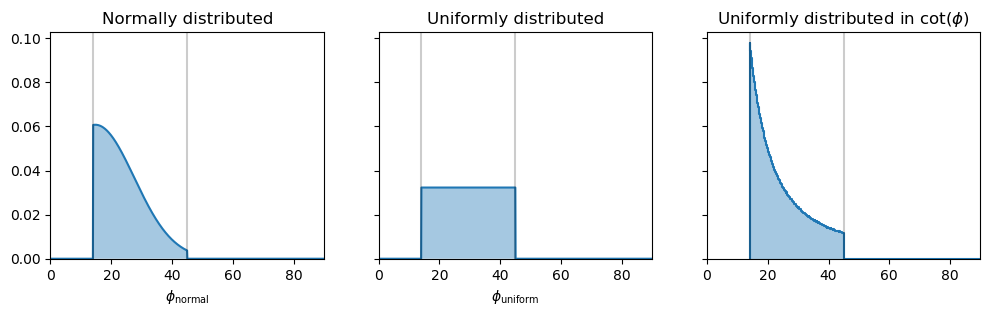

In [9]:
x = np.linspace(0, 90, 1000)
f, ax = plt.subplots(ncols=3, figsize=(12, 3), dpi=100, sharey=True)
plt.sca(ax[0])
y = normal_dist.pdf(x)
plt.plot(x, y, c='C0')
plt.fill_between(x, 0, y, alpha=0.4)
plt.xlim(0, 90)
plt.axvline(acot(4), c='k', alpha=0.2)
plt.axvline(acot(1), c='k', alpha=0.2)
plt.xlabel(r'$\phi_\mathrm{normal}$')
plt.title('Normally distributed')
plt.sca(ax[1])
y = uniform_dist.pdf(x)
plt.plot(x, y, c='C0')
plt.fill_between(x, 0, y, alpha=0.4)
plt.xlim(0, 90)
plt.axvline(acot(4), c='k', alpha=0.2)
plt.axvline(acot(1), c='k', alpha=0.2)
plt.xlabel(r'$\phi_\mathrm{uniform}$')
plt.title('Uniformly distributed')
plt.sca(ax[2])
_rvs = cot_uniform_dist_rvs(int(1E7))
counts, bins, patches = plt.hist(_rvs, density=True, bins='scott', color='C0', alpha=0.4)
plt.step(bins.tolist() + [90], [0] + counts.tolist() + [0])
plt.xlim(0, 90)
plt.axvline(acot(4), c='k', alpha=0.2)
plt.axvline(acot(1), c='k', alpha=0.2)
plt.title(r'Uniformly distributed in $\cot(\phi)$')
del _rvs, counts, bins, patches

# The simple way

Given a distribution of galaxy pitch angles, we want to ask _"does this data look like it has been drawn from this distribution?"_ We can achieve this using the Kolmogorov-Smirnov test. Note that the null hypothesis is that the dataset **is** drawn from the distribution being tested, so we are interested in small p-values.

In [60]:
types = ('Normal', 'Uniform', 'Cot Uniform')
output = pd.DataFrame(
    [], dtype=float,
    index=[f'{i} Dataset' for i in types],
    columns=[f'{i} Model' for i in types],
)
for dataset, dataset_type in zip(
    (normal_dataset, uniform_dataset, cot_uniform_dataset),
    (f'{i} Dataset' for i in types)
):
    p_norm = st.truncnorm.fit(
        dataset,
        (acot(4)-15) / 10, (acot(1) - 15) / 10, loc=20, scale=10
    )
    p_uniform = st.uniform.fit(dataset)
    p_cot_uniform = st.uniform.fit(cot(dataset))
    output.loc[dataset_type] = (
        st.kstest(dataset, st.truncnorm(*p_norm).cdf).pvalue,
        st.kstest(dataset, st.uniform(*p_uniform).cdf).pvalue,
        st.kstest(
            cot(dataset),
            st.uniform(*p_cot_uniform).cdf
        ).pvalue,
    )
display(output.round(2))

,Normal Model,Uniform Model,Cot Uniform Model
Normal Dataset,0.77,0.00,0.68
Uniform Dataset,0.08,0.48,0.00
Cot Uniform Dataset,0.04,0.00,0.63


We can display this more clearly by stating whether we can reject the null hypothesis (that the data could be from this distribution) at the 10% level:

In [62]:
_df = pd.DataFrame(np.where(output < 0.1, 'Reject', 'Accept'), index=output.index, columns=output.columns)
is_accepted = lambda s: ['background-color: #aaffaa' if v else 'background-color: #ffaaaa' for v in s == 'Accept']
display(_df.style.apply(is_accepted))

,Normal Model,Uniform Model,Cot Uniform Model
Normal Dataset,Accept,Reject,Accept
Uniform Dataset,Reject,Accept,Reject
Cot Uniform Dataset,Reject,Reject,Accept


Even at the relatively high 10% level we struggle to reject the possibility that the data was drawn from an incorrect distribution.

## Model defininion using Pymc3

An alternative approach is to use Bayesian inference to perform model comparison, either using LOO cross-validation, or Bayes Factors between models (though this is tricky to compute). The problem we will have with LOO is that as we are simply testing which is the most appropriate posterior to use, our models could fit any theoretical distribution, meaning they are not as robust as they ought to be for proper model comparison.

Define the Normal model using `pymc3`:

In [11]:
def make_normal_model(arms, gal_arm_map, name='Normal'):
    with pm.Model(name) as model:
        # one global mean
        mu_phi_scaled = pm.LogitNormal(
            'mu_phi_scaled',
            mu=0, sigma=1.5,
            testval=0.29
        )

        # one global variance
        mu_phi = pm.Deterministic('mu_phi', 90 * mu_phi_scaled)

        # We need to separate inter- and intra- galaxy stds
        # due to galaxy pitch angle sample truncation
        sigma_phi = pm.InverseGamma(
            'sigma_phi',
            alpha=2, beta=20,
            testval=5
        )
        sigma_gal = pm.InverseGamma(
            'sigma_gal',
            alpha=2, beta=20,
            testval=5
        )

        phi_gal = pm.TruncatedNormal(
            'phi_gal',
            mu=mu_phi, sigma=sigma_phi,
            lower=acot(4), upper=acot(1),
            shape=max(gal_arm_map) + 1
        )

        phi_arm = pm.TruncatedNormal(
            'phi_arm',
            mu=phi_gal[gal_arm_map], sd=sigma_gal,
            lower=0, upper=90,
            shape=len(arms),
            observed=arms,
        )
    return model

Define the Uniform model

In [12]:
def make_uniform_model(arms, gal_arm_map, name='Uniform'):
    with pm.Model(name) as model:
        phi_gal = pm.Uniform(
            'phi_gal',
            lower=acot(4), upper=acot(1),
            shape=max(gal_arm_map) + 1
        )
        # intra-galaxy dispersion
        sigma_gal = pm.InverseGamma(
            'sigma_gal',
            alpha=2, beta=20, testval=5
        )
        phi_arm = pm.TruncatedNormal(
            'phi_arm',
            mu=phi_gal[gal_arm_map], sd=sigma_gal,
            lower=0, upper=90,
            observed=arms,
        )
    return model

And finaly the Cot-Uniform model

In [13]:
def make_cot_uniform_model(arms, gal_arm_map,
                           name='CotUniform'):
    with pm.Model(name) as model:
        cot_phi = pm.Uniform(
            'cot_phi_gal',
            lower=1, upper=4,
            shape=max(gal_arm_map) + 1
        )
        phi_gal = pm.Deterministic(
            'phi_gal', 180 / np.pi * tt.arctan(1 / cot_phi)
        )
        # intra-galaxy dispersion
        sigma_gal = pm.InverseGamma(
            'sigma_gal',
            alpha=2, beta=20, testval=5
        )
        phi_arm = pm.TruncatedNormal(
            'phi_arm',
            mu=phi_gal[gal_arm_map], sd=sigma_gal,
            lower=0, upper=90,
            observed=arms,
        )
    return model

## Inference

We'll test each model against the Normally-distributed sample, and perform some basic model comparison

In [14]:
# hierarchial models can be tricky to fit
with make_normal_model(normal_arms, gal_arm_map) as normal_model:
    normal_trace = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Normal_phi_gal, Normal_sigma_gal, Normal_sigma_phi, Normal_mu_phi_scaled]
Sampling 2 chains: 100%|██████████| 2000/2000 [01:14<00:00, 26.89draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
with make_uniform_model(normal_arms, gal_arm_map) as uniform_model:
    uniform_trace = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Uniform_sigma_gal, Uniform_phi_gal]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:32<00:00, 62.25draws/s] 


In [16]:
with make_cot_uniform_model(normal_arms, gal_arm_map) as cot_uniform_model:
    cot_uniform_trace = pm.sample(target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [CotUniform_sigma_gal, CotUniform_cot_phi_gal]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:27<00:00, 73.86draws/s] 


Now perform the comparison!

In [46]:
pm.compare({normal_model: normal_trace, uniform_model: uniform_trace, cot_uniform_model: cot_uniform_trace}, ic='LOO')

/Users/tlingard/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))
/Users/tlingard/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:300: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")
/Users/tlingard/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:300: UserWarning: Estimated shape

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
Normal,1315.53,34.56,0,0.86,17.09,0,1
CotUniform,1317.54,40.43,2.01,0.08,17.23,3.58,1
Uniform,1329.74,43.74,14.21,0.06,16.34,7.96,1


We can see that the Hierarchial Normal model is preferred here, though as the models are only vaguely specified we end up with a lot of warnings.

What does the posterior on Galaxy pitch angle look like for the different models?

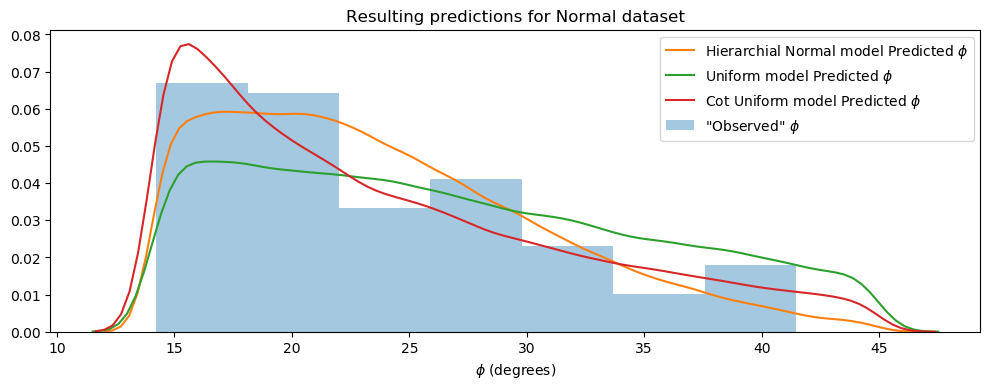

In [49]:
plt.figure(figsize=(12, 4), dpi=100)
plt.title('Resulting predictions for Normal dataset')
sns.distplot(normal_dataset, norm_hist=True, kde=False, label=r'"Observed" $\phi$')
sns.kdeplot(normal_trace['Normal_phi_gal'].ravel(), label=r'Hierarchial Normal model Predicted $\phi$')
sns.kdeplot(uniform_trace['Uniform_phi_gal'].ravel(), label=r'Uniform model Predicted $\phi$')
sns.kdeplot(cot_uniform_trace['CotUniform_phi_gal'].ravel(), label=r'Cot Uniform model Predicted $\phi$')
plt.xlabel(r'$\phi$ (degrees)')
plt.legend();

## Hierarchial model results

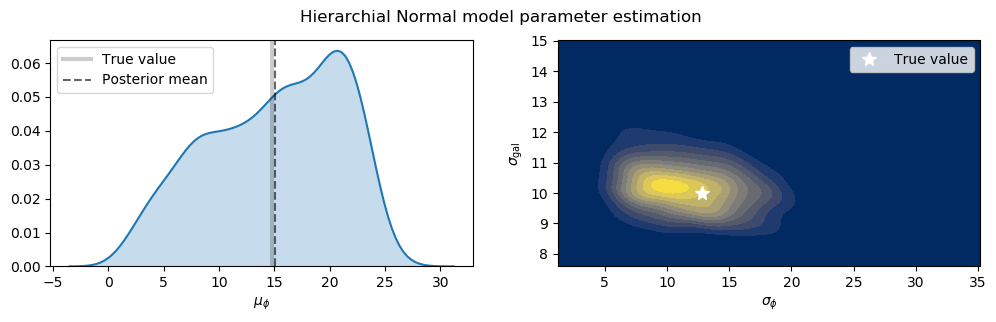

In [63]:
f, ax = plt.subplots(ncols=2, figsize=(12, 3), dpi=100)
plt.suptitle('Hierarchial Normal model parameter estimation')
plt.sca(ax[0])
plt.xlabel(r'$\mu_\phi$')
sns.kdeplot(normal_trace['Normal_mu_phi'].ravel(), shade=True)
plt.axvline(MU_PHI, c='k', alpha=0.2, lw=3, label='True value')
plt.axvline(normal_trace['Normal_mu_phi'].mean(), c='k', ls='--', alpha=0.6, label='Posterior mean')
for i, point in enumerate(normal_trace['Normal_mu_phi'][normal_trace['diverging']]):
    plt.axvline(point, c='r', ls=':', label=(None if i > 0 else 'Diverging sample'))
plt.legend()
plt.sca(ax[1])
plt.xlabel(r'$\sigma_\phi$')
plt.ylabel(r'$\sigma_\mathrm{gal}$')
sns.kdeplot(normal_trace['Normal_sigma_phi'].ravel(), normal_trace['Normal_sigma_gal'].ravel(), shade=True, cmap='cividis')
plt.plot([SD_PHI], [SD_GAL], 'w*', markersize=10, label='True value')
diverging_xs = normal_trace['Normal_sigma_phi'][normal_trace['diverging']]
diverging_ys = normal_trace['Normal_sigma_gal'][normal_trace['diverging']]
if len(diverging_xs) > 0:
    plt.plot(diverging_xs, diverging_ys, 'rx', label='Diverging sample')
plt.legend();

It looks like the model has found the most likely solution, but with slight issues with spread and divergences.

# Cot-uniform dataset

Can we still identify the correct model for the cot-uniform dataset?

In [47]:
# hierarchial models can be tricky to fit
with make_normal_model(cot_uniform_arms, gal_arm_map) as normal_model2:
    normal_trace2 = pm.sample(target_accept=0.95)
with make_uniform_model(cot_uniform_arms, gal_arm_map) as uniform_model2:
    uniform_trace2 = pm.sample(target_accept=0.95)
with make_cot_uniform_model(cot_uniform_arms, gal_arm_map) as cot_uniform_model2:
    cot_uniform_trace2 = pm.sample(target_accept=0.95)
pm.compare({normal_model2: normal_trace2, uniform_model2: uniform_trace2, cot_uniform_model2: cot_uniform_trace2}, ic='LOO')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Normal_phi_gal, Normal_sigma_gal, Normal_sigma_phi, Normal_mu_phi_scaled]
The acceptance probability does not match the target. It is 0.902747183008485, but should be close to 0.95. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Uniform_sigma_gal, Uniform_phi_gal]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [CotUniform_sigma_gal, CotUniform_cot_phi_gal]
/Users/tlingard/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:558: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
CotUniform,1304.77,43.05,0,0.83,16.25,0,1
Normal,1307.57,37.47,2.8,0,16.32,2.88,1
Uniform,1315.62,45.26,10.85,0.17,14.8,8.13,1


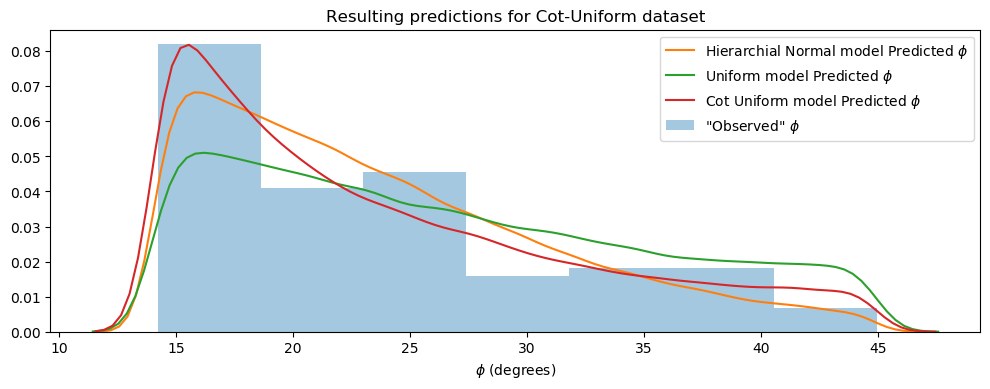

In [48]:
plt.figure(figsize=(12, 4), dpi=100)
plt.title('Resulting predictions for Cot-Uniform dataset')
sns.distplot(cot_uniform_dataset, norm_hist=True, kde=False, label=r'"Observed" $\phi$')
sns.kdeplot(normal_trace2['Normal_phi_gal'].ravel(), label=r'Hierarchial Normal model Predicted $\phi$')
sns.kdeplot(uniform_trace2['Uniform_phi_gal'].ravel(), label=r'Uniform model Predicted $\phi$')
sns.kdeplot(cot_uniform_trace2['CotUniform_phi_gal'].ravel(), label=r'Cot Uniform model Predicted $\phi$')
plt.xlabel(r'$\phi$ (degrees)')
plt.legend();

Yes we can!!